<a href="https://colab.research.google.com/github/carlosramos1/practicas-machine-learning/blob/main/SVM_implementacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
#importar librerias
import numpy as np
from cvxopt import matrix, solvers
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [129]:
# para comparar con mi implementación
from sklearn import svm

# Support Vector Machine

## Problema dual SVM

El problema de minimización esta dado por:

$$
\DeclareMathOperator*{\argmin}{argmin}
\argmin_ \alpha \quad
L(\alpha) = \frac{1}{2}\alpha^T \mathbf H\alpha - \mathbf 1^T \alpha \\
\text{sujeto a: } 0 \leq \alpha \leq C, \quad y^T \alpha = 0
$$

In [130]:
# minimización del problema dual
def min_dual_problem(X, y, C, kernel="linear", gamma=0.5):
  n = X.shape[0]
  y = y.reshape((1,n)) # conversión a array 2D

  K = kernel_matrix(X, X, kernel, gamma)
  #K = X @ X.T # para este ejercicio forzamos a kernel lineal
  H = (y.T @ y) * K

  # Conversión a formato cvxopt
  P = matrix(H)
  q = matrix(-np.ones((n, 1)))
  G = matrix(np.vstack([-np.eye(n), np.eye(n)]))
  h = matrix(np.vstack([np.zeros((n, 1)), C * np.ones((n, 1))]))
  A = matrix(y)
  b = matrix(0.0)

  solvers.options['show_progress'] = False
  solution = solvers.qp(P, q, G, h, A, b)

  # retornar alphas encontrados
  return np.array(solution['x']).flatten()

In [131]:
def kernel_matrix(X1, X2, kernel_type, gamma):
  K = np.zeros((X1.shape[0], X2.shape[0]))

  if kernel_type == "linear":
      for i, xi in enumerate(X1):
          for j, xm in enumerate(X2):
              K[i, j] = np.dot(xi, xm)

  elif kernel_type == "radial":
      for i, xi in enumerate(X1):
          for j, xm in enumerate(X2):
              K[i, j] = np.exp(-gamma * np.linalg.norm(xi - xm) ** 2)

  return K

## Modelo con kernel lineal

### Parametros $\mathbf w$ y $b$ y función de predicción

$$
\mathbf w=\mathbf{X^\intercal \alpha y} 		\\
b=(\mathbf y-\mathbf{Xw})_{\in S}
$$

In [132]:
def get_w_b(alphas, X, y, C):

  # Los support vectors son 0 < alphas < C
  support = (alphas > 1e-5) & (alphas < C - 1e-5)

  w = X.T @ (alphas * y)
  b = y[support] - (X[support] @ w)
  b = np.mean(b)
  return w, b, support

In [133]:
# predecir
def predict_linear_kernel(X, w, b):
  return np.sign(X @ w + b)

### Datos de prueba

Vamos a crear datos de juguete para un modelo con un kernel lineal

In [134]:
# Datos de juguete
n = 2000
X = np.random.rand(n, 2)
y = np.zeros((n,))

np.random.seed(8888)
noise = np.random.uniform(-0.05, 0.05, n)

for i in range(n):
  x1 = X[i][0]
  x2 = X[i][1] + noise[i]
  y[i] = 1.0 if x2 <= 1.0 * x1 else -1.0

X

array([[0.84150526, 0.28810241],
       [0.92794516, 0.23228511],
       [0.25091044, 0.93726583],
       ...,
       [0.28275336, 0.93279021],
       [0.1859059 , 0.35278036],
       [0.25696054, 0.45212096]])

In [135]:
y[:20]

array([ 1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,
        1.,  1.,  1., -1., -1.,  1., -1.])

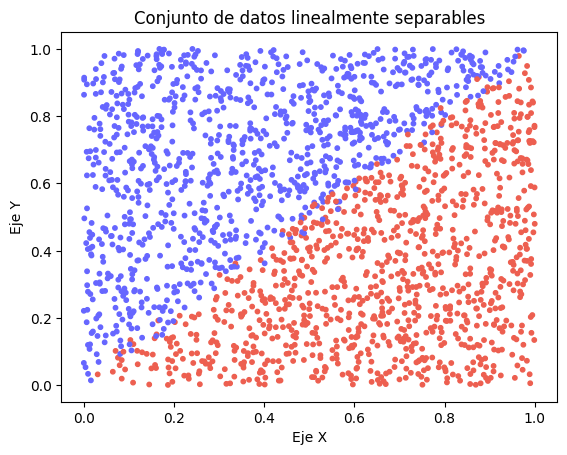

In [136]:
# Graficando los puntos
colors = ["#6666ff" if val == -1 else "#ed5f50" for val in y]

plt.scatter(X[:,0],
            X[:,1],
            c=colors,
            s=10)

plt.title("Conjunto de datos linealmente separables")
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.show()

### Entrenamiento y predicción del modelo

In [137]:
# entrenar el modelo
C = 100.0  # parámetro de regularización
gamma = 0.5
alphas = min_dual_problem(X, y, C, kernel="linear")
w, b, S = get_w_b(alphas, X, y, C)
print('Alphas: ', alphas[S])
print('Support vectors: ', X[S])
print('w: ', w)
print('b: ', b)

Alphas:  [3.09012696e+00 1.75265773e-05 3.03003499e-03 9.69129003e+01
 9.99999895e+01]
Support vectors:  [[0.54781048 0.51771212]
 [0.74659673 0.71452601]
 [0.77246577 0.80105084]
 [0.98288268 0.94900268]
 [0.52687218 0.55617853]]
w:  [ 32.71425176 -33.00109691]
b:  0.15333872526430456


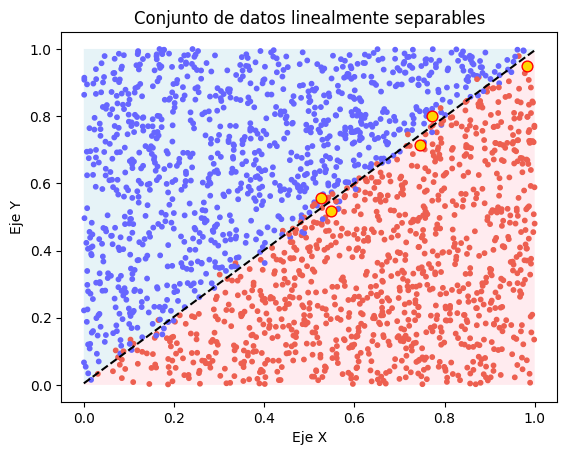

In [138]:
# Graficar los vectores de soporte

# Eje continuo
U = np.linspace(0, 1, 200)
V = -w[0] * U / w[1] - b / w[1]
plt.plot(U, V, 'k--')

# Fondo
plt.fill_between(U, V, 1, facecolor="lightblue", alpha=0.3)       # arriba
plt.fill_between(U, V, 0, facecolor="pink", alpha=0.3)  # abajo


colors = ["#6666ff" if val == -1 else "#ed5f50" for val in y]
plt.scatter(X[:,0],
            X[:,1],
            c=colors,
            s=10)
sv = X[S]
plt.scatter(sv[:,0],
            sv[:,1],
            c="gold",
            s=60,  edgecolors="red")


plt.title("Conjunto de datos linealmente separables")
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.show()

In [139]:
# predecir para los mismos datos
y_hat = predict_linear_kernel(X, w, b)
y_hat[:20]

array([ 1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,
        1.,  1.,  1., -1., -1.,  1., -1.])

In [140]:
# Matriz de confusión
cm = confusion_matrix(y, y_hat)
print(cm)

[[961  27]
 [ 28 984]]


In [141]:
# Medida de aciertos
(cm[0,0]+cm[1,1])/y.size

np.float64(0.9725)

### Comparación con la librería `sklearn`

In [142]:
# Definición del modelo
svm_model = svm.SVC(C=100, kernel='linear')

# Entrenamiento
svm_model.fit(X, np.ravel(y))

SVC(C=100, kernel='linear')

In [143]:
print('Support vectors: ', X[S])
print('w: ', svm_model.coef_)
print('b: ', svm_model.intercept_)
svm_model.coef_, svm_model.intercept_

Support vectors:  [[0.54781048 0.51771212]
 [0.74659673 0.71452601]
 [0.77246577 0.80105084]
 [0.98288268 0.94900268]
 [0.52687218 0.55617853]]
w:  [[ 32.71417394 -33.00098046]]
b:  [0.16386161]


(array([[ 32.71417394, -33.00098046]]), array([0.16386161]))

In [144]:
# Predicción y Matriz de confución
cm_svm = confusion_matrix(svm_model.predict(X),y)
cm_svm

array([[961,  27],
       [ 27, 985]])

El resultado es muy similar a la implementación.

## Kernel de Base Radial (RBF)

### Parámetro $b$ y función de predicción

In [145]:
def get_b_rbf(alphas, X, y, C, gamma):
  # Los support vectors son 0 < alphas < C
  support = (alphas > 1e-5) & (alphas < C - 1e-5)

  b = y[support] - np.sum(alphas * y * kernel_matrix(X[support], X, "radial", gamma), axis=1)
  b = np.mean(b)

  return b, support

In [146]:
def predict_rbf(X_new, X, y, b, alphas, gamma):
    f_x = np.sum(alphas * y * kernel_matrix(X_new, X, "radial", gamma), axis=1) + b
    return np.sign(f_x)

### Datos de prueba

In [147]:
# Datos de juguete dataset para un kernel de base radial
n = 2000

np.random.seed(8888)
noise = np.random.uniform(-0.05, 0.05, n)

X_r = np.random.rand(n, 2)
y_r = np.zeros((n,))
r = 0.3
centre = np.array([0.5, 0.5])

for i in range(n):
    dist = np.linalg.norm(X_r[i] - centre) + noise[i]
    y_r[i] = 1.0 if dist <= r else -1.0

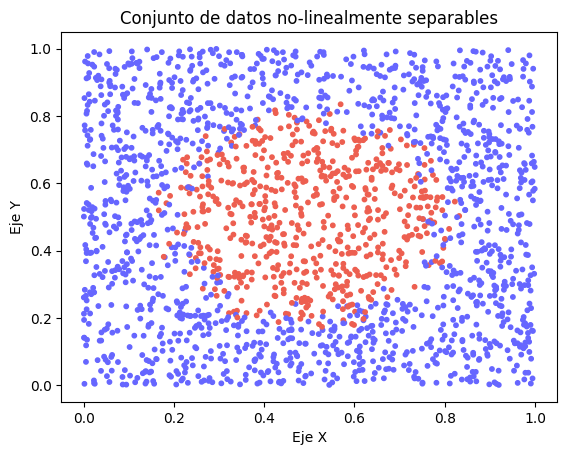

In [148]:
# Graficar los datos
colors = ["#6666ff" if val == -1 else "#ed5f50" for val in y_r]
plt.scatter(X_r[:,0],
            X_r[:,1],
            c=colors,
            s=10)

plt.title("Conjunto de datos no-linealmente separables")
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.show()

### Entrenamiento y predicción

In [149]:
# entrenar el modelo
C = 10.0  # parámetro de regularización
gamma = 0.5
alphas_r = min_dual_problem(X_r, y_r, C, "radial", gamma)
b_r, S_r = get_b_rbf(alphas_r, X_r, y_r, C, gamma)

In [150]:
print('Alphas: ', alphas_r[S_r])
print('Support vectors: ',  X_r[S_r])
print('b: ', b_r)

Alphas:  [3.52195084e+00 6.88671308e+00 1.35604640e-02 1.93619922e+00
 9.00734356e+00 6.12459379e-05 3.07202435e+00 4.39428799e+00]
Support vectors:  [[0.65850105 0.32688404]
 [0.72957875 0.55791283]
 [0.84282288 0.60391412]
 [0.1459955  0.41614066]
 [0.57290998 0.72262605]
 [0.27494644 0.41039235]
 [0.38766925 0.15917762]
 [0.39704071 0.83858523]]
b:  -27.9480975241883


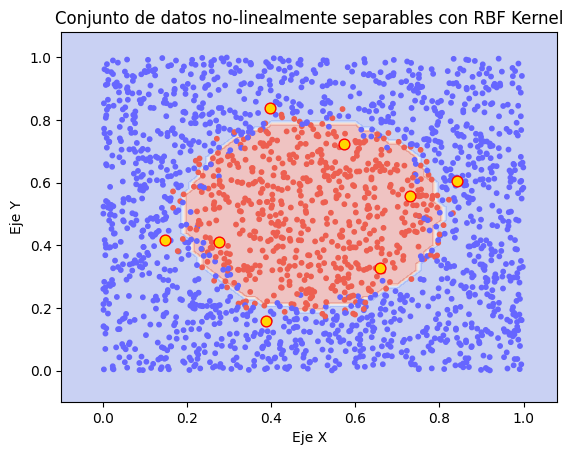

In [151]:
# Graficar los vectores de soporte
# Create a meshgrid to plot the decision boundary
h = .02  # step size in the mesh
x_min, x_max = X_r[:, 0].min() - .1, X_r[:, 0].max() + .1
y_min, y_max = X_r[:, 1].min() - .1, X_r[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict the class for each point in the meshgrid
Z = predict_rbf(np.c_[xx.ravel(), yy.ravel()], X_r, y_r, b_r, alphas_r, gamma)
Z = Z.reshape(xx.shape)

# Plot the decision boundary and the data points
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)

# Plot the data points
colors = ["#6666ff" if val == -1 else "#ed5f50" for val in y_r]
plt.scatter(X_r[:,0],
            X_r[:,1],
            c=colors,
            s=10)

# Plot the support vectors
sv = X_r[S_r]
plt.scatter(sv[:,0],
            sv[:,1],
            c="gold",
            s=60,  edgecolors="red")

plt.title("Conjunto de datos no-linealmente separables con RBF Kernel")
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.show()

In [152]:
# predecir para los mismos datos
#y_hat = predict_rbf(X_r, X_r[S_r], y_r[S_r], b_r, alphas_r[S_r], gamma)
y_hat = predict_rbf(X_r, X_r, y_r, b_r, alphas_r, gamma)
y_hat[:20]

array([-1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1.,  1., -1., -1.,
       -1., -1.,  1., -1., -1., -1., -1.])

In [153]:
# Matriz de confusión
cm = confusion_matrix(y_r, y_hat)
print(cm)

[[1358   58]
 [  51  533]]


In [154]:
# Medida de aciertos
(cm[0,0]+cm[1,1])/y_r.size

np.float64(0.9455)

### Comparacion con la libreria sklearn

In [155]:
# Definición del modelo
svm_model = svm.SVC(C=10, kernel='rbf', gamma=0.5)

# Entrenamiento
svm_model.fit(X_r, np.ravel(y_r))

SVC(C=10, gamma=0.5)

In [156]:
svm_model.intercept_

array([-27.94624621])

In [157]:
#svm_model.coef_  #error: coef_ is only available when using a linear kernel

In [158]:
# Predicción y Matriz de confución
cm_svm = confusion_matrix(svm_model.predict(X_r),y_r)
cm_svm

array([[1358,   51],
       [  58,  533]])

Los resultados son muy similares

**Observaciones**:
- La implementación manual tiene la restriccion de $0<\alpha<C$ en cambio en la `sklearn` implementa $0<\alpha$ es por eso que varia en la cantidad de *support vectors*.
- Los parámetros $b$ y $w$ calculados manualemente y las `sklearn` son muy similares.
- Tanto la implementación como la de `sklearn` tiene la misma cantidad de aciertos y fracasos en la clasificación (se hizo la comparación mediante la matriz de confusión).